In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

def bias(x, y): return np.mean(x - y)

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
lievens_params = [2, 0.5, 0.44]
# wus_params = [2.5, 0.2, 0.55]
wus_v2_params = [1.5, 0.1, 0.59]

in_dir = Path('~/spicy-snow/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.1), 2)
B = np.round(np.arange(0, 2.01, 0.1), 2)
C = np.round(np.arange(0, 1.001, 0.01), 2)

def get_stats(x, y):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [19]:
npy_dirs = Path('/bsuhome/zacharykeskinen/scratch/spicy/param_npys')
all_res = xr.open_dataset(npy_dirs.joinpath('grouped.nc'))
A = all_res['pearsonr'].max(['B', 'C']).idxmax('A')
B = all_res['pearsonr'].max(['C', 'A']).idxmax('B')
print(A)
print(B)
print(all_res['mae'].sel(A = A, B = B).idxmin('C'))

res_un = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/spicy/param_npys/param_stats_all.nc')
res_high = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/spicy/param_npys/param_stats_high_fcf.nc')
res_low = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/spicy/param_npys/param_stats_low_fcf.nc')

<xarray.DataArray 'A' ()>
array(1.5)
<xarray.DataArray 'B' ()>
array(0.)
<xarray.DataArray 'C' ()>
array(0.6)
Coordinates:
    A        float64 1.5
    B        float64 0.0


In [16]:
all_res['mae'].sel(A = 1.5, B = 0.1).idxmin('C')

<xarray.DataArray 'C' ()>
array(0.6)
Coordinates:
    A        float64 1.5
    B        float64 0.1

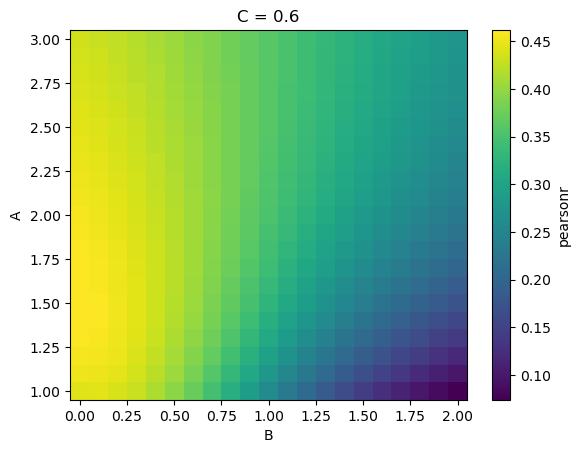

In [15]:
all_res['pearsonr'].sel(C = 0.6).plot()

In [96]:
# res = pd.DataFrame()
# # wus_v2_params
# for ds, row_name in zip([res_un, res_low, res_high], ['All Pixels', '<25% FCF', '>75% FCF']):
#     for stat in ['rmse', 'pearsonr']:
#         for param in ['A','B','C']:

#             if param == 'A':
#                 c_best = ds.sel(C = ds['mae'].idxmin('C'))
#                 sub_best = c_best.sel(B = c_best['pearsonr'].idxmax('B'))
#             if param == 'B':
#                 c_best = ds.sel(C = ds['mae'].idxmin('C'))
#                 sub_best = c_best.sel(A = c_best['pearsonr'].idxmax('A'))
#             if param == 'C':
#                 res_drop = ds.dropna('C')
#                 a_best = res_drop.sel(B = res_drop['pearsonr'].idxmax('B'))
#                 sub_best = a_best.sel(A = a_best['pearsonr'].idxmax('A'))
            
#             d_stat = np.abs(sub_best[stat].differentiate(param)).mean()
#             res.loc[row_name, f'$\delta {stat} / \delta$ {param}'] = d_stat

In [5]:
res = pd.DataFrame()
# wus_v2_params
for ds, row_name in zip([res_un, res_low, res_high], ['All Pixels', '<25% FCF', '>75% FCF']):
    for stat in ['rmse', 'pearsonr']:
        for param in ['A','B','C']:
            

            if param == 'A':
                sub_best = ds.sel(C = wus_v2_params[2], B = wus_v2_params[1])
            if param == 'B':
                sub_best = ds.sel(A = wus_v2_params[0], C = wus_v2_params[2])
            if param == 'C':
                res_drop = ds.dropna('C')
                sub_best = res_drop.sel(A = wus_v2_params[0], B = wus_v2_params[1])
            
            d_stat = np.abs(sub_best[stat].differentiate(param)).mean()
            res.loc[row_name, f'$\delta {stat} / \delta$ {param}'] = d_stat

In [6]:
ds

<xarray.Dataset>
Dimensions:   (location: 9, A: 21, B: 21, C: 101)
Coordinates:
  * location  (location) object 'Banner_2020-02-18' ... 'Mores_2021-03-15'
  * A         (A) float64 1.0 1.1 1.2 1.3 1.4 1.5 ... 2.5 2.6 2.7 2.8 2.9 3.0
  * B         (B) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 1.5 1.6 1.7 1.8 1.9 2.0
  * C         (C) float64 0.0 0.01 0.02 0.03 0.04 ... 0.96 0.97 0.98 0.99 1.0
Data variables:
    pearsonr  (location, A, B, C) float64 nan 0.1847 0.1847 ... 0.1509 0.1509
    mae       (location, A, B, C) float64 1.31 1.307 1.305 ... 1.802 1.824 1.847
    rmse      (location, A, B, C) float64 1.332 1.329 1.327 ... 2.312 2.342
    bias      (location, A, B, C) float64 -1.31 -1.307 -1.305 ... 1.08 1.106

In [7]:
res.T.applymap(lambda x: f'{x:.3f}').to_csv(Path('~/spicy-analysis/results/params/param_table_v2.csv'))

In [9]:
res.T.applymap(lambda x: f'{x:.3f}')

,All Pixels,<25% FCF,>75% FCF
$\delta rmse / \delta$ A,0.207,0.454,0.144
$\delta rmse / \delta$ B,0.176,0.019,0.367
$\delta rmse / \delta$ C,0.908,1.871,0.412
$\delta pearsonr / \delta$ A,0.035,0.047,0.030
$\delta pearsonr / \delta$ B,0.101,0.013,0.226
$\delta pearsonr / \delta$ C,0.000,0.000,0.000
